In [132]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as ss

In [133]:

def readmesh(fname):
    """
    Read a mesh file and return vertics as a (npts, 2)
    numpy array and triangles as (ntriangles, 3) numpy
    array. `npts` is the number of vertices of the mesh
    and `ntriangles` is the number of triangles of the
    mesh.
    """

    with open(fname, "r") as f:
        npoints = int(next(f))
        points = np.zeros((npoints, 2))
        for i in range(npoints):
            points[i, :] = [float(x) for x in next(f).split()]

        ntriangles = int(next(f))
        triangles = np.zeros((ntriangles, 3), dtype=int)
        for i in range(ntriangles):
            triangles[i, :] = [int(x)-1 for x in next(f).split()]

    return points, triangles


def plotmesh(points, triangles, tricolors = None):
    """
    Given a list of points (shape: (npts, 2)) and triangles
    (shape: (ntriangles, 3)), plot the mesh.
    """

    plt.figure()
    plt.gca().set_aspect('equal')
    if tricolors is None:
        plt.triplot(points[:, 0], points[:, 1], triangles, 'bo-', lw=1.0)
    else:
        plt.tripcolor(points[:, 0], points[:, 1], triangles, facecolors=tricolors, edgecolors='k')
    return


def mesh2dualgraph(triangles):
    """
    Calculate the graph laplacian of the dual graph associated
    with the mesh given by numpy array traingles.
    """

    n, m = triangles.shape

    assert(m == 3), "Triangle should have exactly three points !!"

    G = np.zeros((n, n))

    for i, ti in enumerate(triangles):
        for j, tj in enumerate(triangles):
            ## If there is a common edge
            if len( set(ti) - set(tj) ) == 1:
                G[i, j] = G[j, i] = -1

    for i in range(n):
        G[i, i] = -np.sum(G[i, :])

    return ss.csr_matrix(G)

In [134]:
def lanczos(A, x0, iterations):
    q1=x0
    q1=q1/np.linalg.norm(q1)
    q0=0.*q1
    betak=0.
    T=np.zeros((iterations,iterations))
    print (T.shape)
    Q=np.zeros((A.shape[1],iterations))
    for k in range(iterations):
        Q[:,k]=q1
        u=np.dot(A.toarray(),q1)
        alphak=np.dot(q1.T,u)
        u=u-betak*q0-alphak*q1
        betak=np.linalg.norm(u)
        q0=q1
        q1=u/betak
        T[k,k]=alphak
        if k<iterations-1:
            T[k,k+1] = betak
            T[k+1,k] = betak
    #Implement the body of the function
    return Q, T

In [135]:
def fiedler(G, k):
    """
    Calculate the fiedler vector of the graph Laplacian matrix
    `G` using `k` iterations of Lanczos algorithm.
    """
    n, m = G.shape

    assert (n == m), "Matrix should be square !!"

    x0 = np.linspace(1, n, num=n)

    ## You should complete this Lanczos function
    Q, T = lanczos(G, x0, k)

    eVal, eVec = np.linalg.eig(T)
    idx = eVal.argsort()
    eVal = eVal[idx]
    eVec = eVec[:,idx]
    fiedlerVec = np.dot(Q, eVec[:, 1])

    partitionVec = np.zeros_like(fiedlerVec)
    mfeidler = np.ma.median(fiedlerVec)

    for i in range(n):
        if fiedlerVec[i] >= mfeidler:
            partitionVec[i] = 1
        else:
            partitionVec[i] = -1

    return partitionVec

(150, 150)


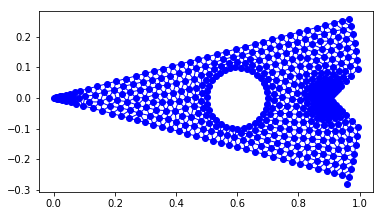

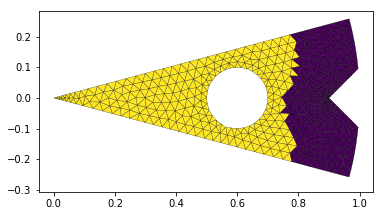

In [136]:
plt.close()
points, triangles = readmesh("mesh.1")
plotmesh(points, triangles)
G = mesh2dualgraph(triangles)
partitionVec = fiedler(G, 150)
plotmesh(points, triangles, partitionVec)
plt.show()